## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import os
import numpy as np
import math as m 
from scipy import stats 
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda
from numba import vectorize, int64, float32, int32

a=np.array([2,5,10,3,8])
#print(a)

@vectorize([float32(int64)], target='parallel', fastmath=True)
def expo(x):
    c=m.exp(x)
    return c

@vectorize([float32(int64)], target='parallel', fastmath=True)
def loga(x):
    c=m.log(x)
    return c

print(expo(a))
print(loga(a))

[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]
[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [2]:
@jit
def gaus(x):
    mean=1
    s=1
    a=np.exp(-((x-mean)/s)**2/2)/(s*m.sqrt(2*m.pi))
    return a
 
size=10000
x=np.linspace(-3,3,size)

a=gaus(x)
print(a)


[0.00013383 0.00013415 0.00013447 ... 0.05412067 0.05405579 0.05399097]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

[ 1  0 -2 ... -3  1  4]
[0 0 0 ... 0 0 0]


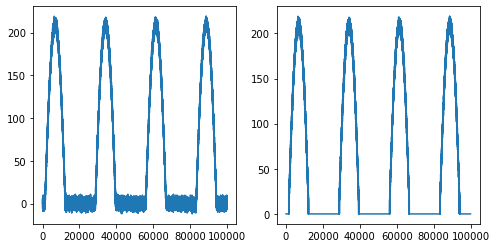

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

@jit
def zerosup(x, th):
    a=[]
    for i in x:
        if i<th:
            a.append(0)
        else:
            a.append(i)
    return np.array(a)

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

th=15

print(data)

x=np.linspace(0,n,n)
fig, (ax1,ax2) =plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax1.plot(x,data)

data2=zerosup(data,th)
print(data2)
ax2.plot(x,data2)


## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
@jit
def sig_ker(x,y):
    a=2
    c=3
    x=a*x
    z=np.tanh(x.T*y+c)
    return z


X = np.random.rand(3,3)
Y = np.random.rand(3,3)

Z=sig_ker(X,Y)

print(Z)



[[0.99770494 0.99759478 0.99905229]
 [0.9987065  0.99649087 0.99709611]
 [0.99646398 0.99795264 0.99888082]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [5]:
from __future__ import division
from numba import cuda
import numpy as np
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """#Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(1,100, size=(24,12))
B = np.random.randint(1,100, size=(12,22))
C = np.zeros((24,12))

# Configure the blocks
threadsperblock = (8,8)
blockspergrid_x = (A.shape[0]+ (threadsperblock - 1)) // threadsperblock
blockspergrid_y = ( B.shape[1]+ (threadsperblock - 1)) // threadsperblock
blockspergrid = np.array(blockspergrid_x,blockspergrid_y)
double_kernel[blockspergrid, threadsperblock](A,B,C)





TypeError: unsupported operand type(s) for -: 'tuple' and 'int'